In [1]:
import sys
import json
import numpy as np
import pandas as pd
import tensorflow as tf
sys.path.append("../")
from src.Evaluation import plot_model_history
from src.ModelBuilder import get_MLP, get_MCDCNN, get_Time_CNN, get_FCN
from src.LoadData import get_all_datasets_test_train_np_arrays
from src.Helpers import append_to_csv

In [2]:
path_to_datasets = "../datasets"

In [3]:
datasets_test_train_data = get_all_datasets_test_train_np_arrays(path_to_datasets)

In [4]:
models_getter = [get_MLP, get_MCDCNN, get_Time_CNN, get_FCN]
models_names = ["MLP", "MCDCNN", "Time_CNN", "FCN"]

In [5]:
tf.debugging.set_log_device_placement(True)
# devices = tf.config.list_logical_devices('GPU') # Use this to run training just on GPUs
devices = tf.config.list_logical_devices()
strategy = tf.distribute.MirroredStrategy(devices)

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [6]:
devices

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

In [7]:
path_persist_results = "./training_res.csv"
columns = ["dataset_name", "model_name", "test_loss", "test_acc", "confusion_matrix", "history"]
append_to_csv(path_persist_results, columns)

In [8]:
epochs = 30
batch_size = 10
validation_split = 0.2

In [29]:
with strategy.scope():
    for ds_name, ds_data in datasets_test_train_data.items():
        print("Dataset name: ", ds_name)
        x_test, y_test = ds_data["test_data"]
        x_train, y_train = ds_data["train_data"]

        input_size = x_train.shape[1]
        output_size = len(np.unique(y_train))
        for get_model, model_name in zip(models_getter, models_names):
            print("Model name: ", model_name)
            model = get_model(input_size, output_size)
            model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])
            history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split)
            test_loss, test_acc = model.evaluate(x_test, y_test)
            # TODO: add confusion matrix

            row = [ds_name,
                  model_name,
                  test_loss,
                  test_acc,
                  None, # TODO: persist confusion matrix to further analysis
                  json.dumps(history.history)]
            append_to_csv(path_persist_results, row)

Dataset name:  abnormal_heartbeat
Model name:  MLP
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op NoOp in device /job:localhost/replica:0/task:0/device:CPU

KeyboardInterrupt: 

# Example load training results and display evaluation results

In [9]:
df_training_res = pd.read_csv(path_persist_results)

In [10]:
df_training_res

,dataset_name,model_name,test_loss,test_acc,confusion_matrix,history
0,abnormal_heartbeat,MLP,4.677855968,0.717073143,NaN,"{""loss"": [0.45849764347076416, 0.3600711226463..."
1,dataset_name,model_name,test_loss,test_acc,confusion_matrix,history


In [11]:
history = df_training_res['history'][0]

Highest Validation Accuracy: 0.09756097197532654


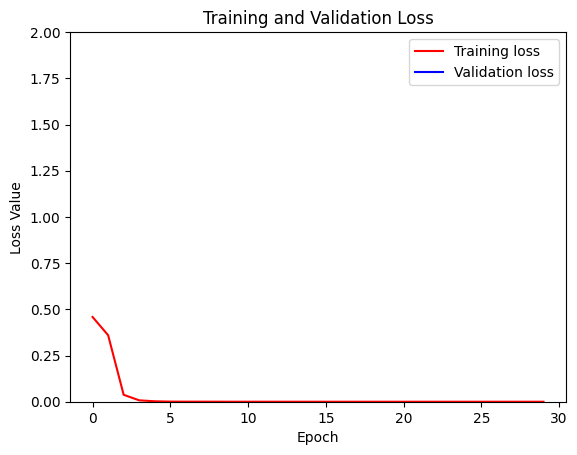

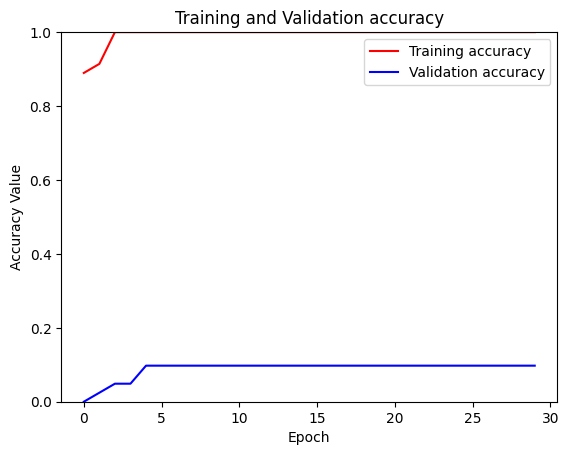

In [13]:
plot_model_history(json.loads(history), epochs=epochs)